Install core Simulation Python Libraries

In [0]:
%pip install simpy pandas seaborn sympy beautifulsoup4 lxml html5lib
%pip install pint
%pip install modsimpy

## War Card Game simulator

In the standard card game, War, there are several rule variants on how many face down cards should be placed during the "war" phase.  In the official Bicycle Crds Games Rules, they say 1 face down card, then one face up card to determine the winner.  My wife grew up placing 2 face down cards and the a face up card.  I grew up placing 3 face down cards and then a face up (while saying the syllables "I-de-clare-war").

In this simulation, I will test the impact on how long games last across these different rules variants.  I'm also curious whether the number of face-down cards during the "war" phase affects players being able to win from behind (where their card count dropped below 26).

We will use a standard deck of 52 cards (no jokers).

Variants:
* 1 Face down cards, then 1 face up
* 2 Face down cards, then 1 face up
* 3 Face down cards, then 1 face up

We will run 1000 games with each variant.  Note that the Game of War is stochasitic based on how the cards are dealt and the random shuffle when picking up the win pile to refill the player's hand.  Since, the player has no direct choice when playing, the outcome is random and we expect Player 1 and Player 2 to win with equal probability.  

In [0]:
import random
import pandas as pd


# ==============================================================================
def build_shuffled_deck():
    """Build a standard 52 card deck and shuffle it"""
    deck = []
    for suit in ['C', 'D', 'H', 'S']:
        for rank, card in enumerate([2, 3, 4, 5, 6, 7, 8, 9, 10, 'J', 'Q', 'K', 'A']):
            deck = deck + [(f'{card}{suit}', rank)]
    
    random.shuffle(deck)
    return deck


# ==============================================================================
def deal_deck(deck):
    """Deal given deck into 2 piles and return them

    deck: List of card tuples (card, rank)
    """
    p1_deck = deck[:26]
    p2_deck = deck[26:]
    
    return p1_deck, p2_deck


# ==============================================================================
def shuffle_win_pile(player):
    """If player's deck is empty and they have cards in their win pile,
    pick them up and shuffle them into their hand

    player: Player dict object
    """
    if len(player['deck']) == 0 and len(player['win_pile']) > 0:
        player['deck'] = player['win_pile']
        player['win_pile'] = []
        random.shuffle(player['deck'])
    
    return player


# ==============================================================================
def war(p1, p2, face_down_cards):
    """Handle a war between 2 players

    p1: Player dict object
    p2: Player dict object
    """
    # Edge case where a player plays last card in war and cannot do a
    # second war
    
    # The varinat determines how many face down, but then add 1 for the face up card
    total_cards_to_place = face_down_cards + 1

    for i in range(0, total_cards_to_place):
        # Each player put a card down, note if a player runs
        # out of cards, their last face up card is counted for comparison
        # If a player cannot put any cards down, then they loose since
        # they cannot fight the war at all
        
        for p in [p1, p2]:
          if len(p['deck']) > 0:
              p['kitty'] = p['kitty'] + [p['deck'].pop()]
          
          else:
              p = shuffle_win_pile(p)
              
              if len(p['deck']) > 0:
                  p['kitty'] = p['kitty'] + [p['deck'].pop()]
              
              else:
                  if len(p['kitty']) == 0:
                      p['out'] = True
    
    # --- See who won or whether we have another war ---
    if p1['out'] is False and p2['out'] is False:
        # Player 1 wins
        if p1['kitty'][-1][1] > p2['kitty'][-1][1]:
            p1['win_pile'] = p1['win_pile'] + p1['kitty'] + p2['kitty']
        
        # Player 2 wins
        elif p2['kitty'][-1][1] > p1['kitty'][-1][1]:
            p2['win_pile'] = p2['win_pile'] + p1['kitty'] + p2['kitty']
            
        # ANOTHER WAR
        else:
            war(p1, p2, face_down_cards)

        p1['kitty'] = []
        p2['kitty'] = []

    # --- Someone went out - game is over
    else:
        if p1['out'] is True:
            p2['win_pile'] = p2['win_pile'] + p1['kitty'] + p2['kitty']
        else:
            p1['win_pile'] = p1['win_pile'] + p1['kitty'] + p2['kitty']
    
    return p1, p2


# ==============================================================================
def run_simulation(game, face_down_cards):
    """Main Game Loop

    game: Integer
    """
    global BORED_TIMEOUT
    
    # Build a deck of cards and deal
    deck = build_shuffled_deck()
    p1_deck, p2_deck = deal_deck(deck)
    
    # Setup player objects (dict) for passing around
    p1 = {'deck'       : p1_deck.copy(),
          'win_pile'   : [],
          'kitty'      : [],
          'least_cards': 26,
          'most_cards' : 26,
          'out'        : False}
    
    p2 = {'deck'       : p2_deck.copy(),
          'win_pile'   : [],
          'kitty'      : [],
          'least_cards': 26,
          'most_cards' : 26,
          'out'        : False}
    
    del p1_deck, p2_deck
    
    turns = 0  # Track current turn number
    tie = False  # Did game exceed a reasonable number of turns
    winner = 0  # Who won
    
    # PLAY THE GAME
    while len(p1['deck']) > 0 and len(p2['deck']) > 0:
        turns += 1
        
        # Players get bored after this number of turns and call it a tie
        if turns > BORED_TIMEOUT:
            tie = True
            break
        
        # Each player takes the top card and plays
        p1_card = p1['deck'].pop()
        p2_card = p2['deck'].pop()
        
        # Player 1 card wins
        if p1_card[1] > p2_card[1]:
            p1['win_pile'] = p1['win_pile'] + [p1_card, p2_card]
        
        # Player 2 card wins
        elif p2_card[1] > p1_card[1]:
            p2['win_pile'] = p2['win_pile'] + [p1_card, p2_card]
        
        # Tie - WAR!
        else:
            p1['kitty'] = [p1_card]
            p2['kitty'] = [p2_card]
            
            p1, p2 = war(p1, p2, face_down_cards)
        
        # if the player's deck is exhausted and they have a win pile, shuffle it
        # into their hand
        p1 = shuffle_win_pile(p1)
        p2 = shuffle_win_pile(p2)
        
        # --- Update metrics for each player on how many cards they have total
        for p in [p1, p2]:
          if len(p['deck']) + len(p['win_pile']) > p['most_cards']:
              p['most_cards'] = len(p['deck']) + len(p['win_pile'])
          
          if len(p['deck']) + len(p['win_pile']) < p['least_cards']:
              p['least_cards'] = len(p['deck']) + len(p['win_pile'])
        
        # --- Check if we have a winner ---
        
        # Player 1 wins
        if len(p1['deck']) == 0:
            winner = 2
            break
        
        # Player 2 wins
        if len(p2['deck']) == 0:
            winner = 1
            break
    
    # --- Print and Return Results ---
    if tie:
        # print(f'Game #{game} took to long and was a draw  :(')
        return game, face_down_cards, turns, winner, p1['least_cards'], p1['most_cards'], p2['least_cards'], p2['most_cards']
    else:
        # print(f'Game #{game} winner: Player {winner} after {turns} turns')
        return game, face_down_cards, turns, winner, p1['least_cards'], p1['most_cards'], p2['least_cards'], p2['most_cards']


# =============================
# MAIN
# =============================
NUM_OF_GAMES = 3000   # Number of games to simulate
BORED_TIMEOUT = 2000  # Turn limit for a game - after which its dinnertime and players call a draw
results = []

for g in range(1, NUM_OF_GAMES + 1):
    war_face_down_cards = g % 3 + 1
    sim_result = run_simulation(g, war_face_down_cards)
    results = results + [sim_result]

df = pd.DataFrame(results, columns=['Game', 'War_Variant', 'Turns', 'Winner', 'P1_Least', 'P1_Most', 'P2_Least', 'P2_Most'])


## Analysis

### Game Length

How long (in turns) do games last depending on the number of face-down "war" cards?

              Game  War_Variant  ...     P2_Least      P2_Most
count  3000.000000  3000.000000  ...  3000.000000  3000.000000
mean   1500.500000     2.000000  ...     8.225667    43.554000
std     866.169729     0.816633  ...     9.758816     9.897192
min       1.000000     1.000000  ...     0.000000    26.000000
25%     750.750000     1.000000  ...     0.000000    34.000000
50%    1500.500000     2.000000  ...     0.000000    51.000000
75%    2250.250000     3.000000  ...    18.000000    52.000000
max    3000.000000     3.000000  ...    26.000000    52.000000

[8 rows x 8 columns]
Winner
0       6
1    1501
2    1493
Name: Game, dtype: int64


Text(0, 0.5, 'Density')

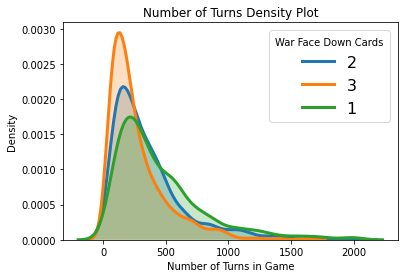

In [0]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

print(df.describe())

print(df.groupby('Winner').count()['Game'])

for variant in df['War_Variant'].unique():
  subset = df[df['War_Variant'] == variant]
  sns.distplot(subset['Turns'], hist = False, kde = True,
               kde_kws = {'shade': True, 'linewidth': 3}, label = variant)

# sns.distplot(df['Turns'], hist=True, kde=True,
#              bins=int(180/5), label='War_Variant',
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})

plt.legend(prop={'size': 16}, title = 'War Face Down Cards')
plt.title('Number of Turns Density Plot')
plt.xlabel('Number of Turns in Game')
plt.ylabel('Density')


### Wins from Behind

When each player won, what was their lowest card count?  What is the probability for winning from behind?

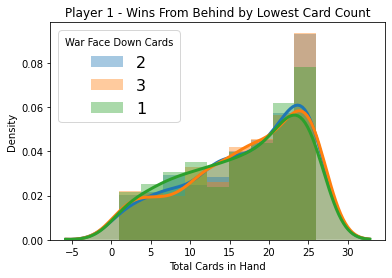

In [0]:
# Player 1 
for variant in df['War_Variant'].unique():
  subset = df[(df['Winner'] == 1) & (df['War_Variant'] == variant)]
  sns.distplot(subset['P1_Least'], hist = True, kde = True,
               kde_kws = {'shade': True, 'linewidth': 3}, label = variant)

plt.legend(prop={'size': 16}, title = 'War Face Down Cards')
plt.title('Player 1 - Wins From Behind by Lowest Card Count')
plt.xlabel('Total Cards in Hand')
plt.ylabel('Density')
plt.show()

## Discussion:

* Out of 3000 games, we had 6 that exceeded our timeout of 2000 turns (at which point any child will be bored and want to do something else).  1501 games went to Player 1 and 1493 went to Player 2.  This is essentailly 50% chance of winning which was our expectation.

* The number of face down cards has a definite impact on how long games take to complete.  The fewer face down cards lead to longer games.  When we increase the number of face down cards, games tend to finish in fewer turns.

* The number of face down cards doesn't seem to impact the chance of players winning from behind.  The fewer cards you have at in your hand is associated with a lower probability of winning.  